In [1]:
from functools import partial

import torch
import torch.nn as nn
import numpy as np

import wandb
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from NeuralGraph import NeuralGraph
from message import *
from update import *
from attention import *

In [2]:
DEVICE = 'cpu'
BS = 64
NODES = 10

ch_n = 8
ch_e = 8
ch_k = 8
ch_extra = 20

message_gen = lambda ch_n, ch_e, ch_extra: nn.Sequential(
    nn.Linear((ch_n+ch_extra)*2 + ch_e, ch_n*2 + ch_e),
    nn.ReLU(),
)

update_gen = lambda ch_n, ch_extra: nn.Sequential(
    nn.Linear(ch_n*3 + ch_extra, ch_n),
)

attention_gen = lambda ch_n, ch_k, ch_extra: nn.Sequential(
    nn.Linear(ch_n+ch_extra, ch_k*4),
)


ngraph = NeuralGraph(
    NODES, 1, 1,
    message_generator=message_gen,
    update_generator=update_gen,
    attention_generator=attention_gen,
    aggregation='attention',
    value_init='trainable',
    connections=[(x,y) for x in range(NODES) for y in range(NODES)],
    ch_n=ch_n, ch_e=ch_e, ch_k=ch_k,
    ch_inp=8, ch_out=8,
    n_models=1,
    use_label=True,
#     leakage=0.5,
    device=DEVICE
)

In [8]:
ngraph.nodes.shape

torch.Size([7, 10, 8])

In [20]:
STEPS = 2_500

criterion = nn.MSELoss()

# optimizer = torch.optim.RMSprop(ngraph.parameters(), lr=1e-2, weight_decay=0.0)
optimizer = torch.optim.Adam(ngraph.parameters(), lr=1e-2, weight_decay=0.0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, STEPS)
log = []

In [21]:
bar = tqdm(range(STEPS))
for i in enumerate(bar):
    x = torch.randn(size=(5, BS, 1, 8), device=DEVICE).float()
    y = torch.randn(size=(5, BS, 1, 8), device=DEVICE).float()

    ngraph.init_vals(batch_size=BS)
    timesteps = 10
    out = []

    for t in range(5):
        ngraph.apply_vals(x[t], y[t])
        ngraph.timestep(nodes=True, edges=False, dt=1, t=0)
        ngraph.timestep(nodes=True, edges=False, dt=1, t=1)
        ngraph.timestep(nodes=True, edges=False, dt=1, t=2)
        # ngraph.timestep(nodes=True, edges=True, dt=0.5, t=t*2)
        # ngraph.timestep(nodes=True, edges=True, dt=0.5, t=t*2+1)
        
        ngraph.timestep(nodes=True, edges=True, dt=1, t=0)

    indices = np.arange(5)
    # indices = [4,3,2,1,0]
    np.random.shuffle(indices)
    
    for t, i in enumerate(indices):
        ngraph.apply_vals(x[i])
        ngraph.timestep(nodes=True, edges=False, dt=1, t=0)
        ngraph.timestep(nodes=True, edges=False, dt=1, t=1)
        ngraph.timestep(nodes=True, edges=False, dt=1, t=2)

        ngraph.timestep(nodes=True, edges=True, dt=1, t=0)
        out.append(ngraph.read_outputs())

    y_hat = torch.stack(out)
    y_true = y[indices]

    task_loss = criterion(y_true, y_hat)
    overflow = ngraph.overflow()
    loss = task_loss + overflow
    
    if ngraph.leakage <= 0.001:
        ngraph.leakage = 0
    elif loss.item() < 0.2:
        ngraph.leakage -= 0.1

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(ngraph.parameters(), 1.0)
    optimizer.step()
    scheduler.step()

    mgrad = torch.norm(next(ngraph.messages.parameters()).grad.detach())
    ugrad = torch.norm(next(ngraph.updates.parameters()).grad.detach())
    node_grad = torch.norm(ngraph.init_nodes.grad)
    edge_grad = torch.norm(ngraph.init_edges.grad)
    
    entry = {
        'loss': task_loss.item(),
        'overflow': overflow.item(),
        'mgrad': mgrad.item(),
        'ugrad': ugrad.item(),
        'node_grad': node_grad.item(),
        'edge_grad': edge_grad.item(),
    }
    
    bar.set_postfix(entry)
    log.append(entry)
print(f'final loss: {log[-1]["loss"]:.4f}')

  0%|          | 0/2500 [00:00<?, ?it/s]

final loss: 0.1103


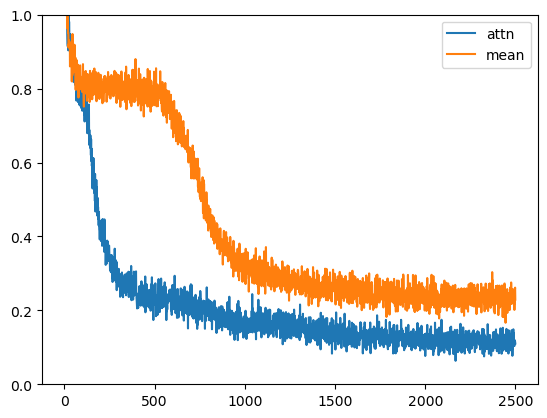

In [24]:
# my_log = torch.load("my_log.pt")
plt.plot([e["loss"] for e in attn_log], label='attn')
plt.plot([e["loss"] for e in mean_log], label='mean')
plt.ylim(0, 1)
plt.legend()
plt.show()

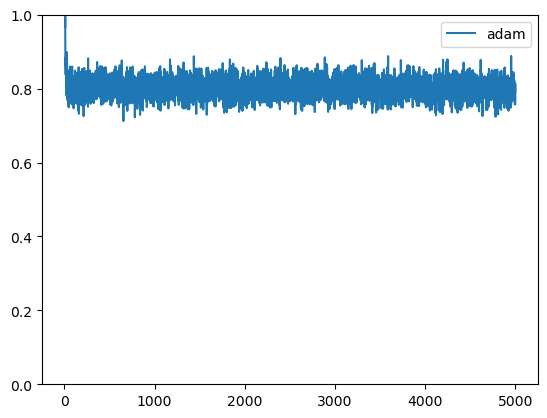

In [102]:
# my_log = torch.load("my_log.pt")
plt.plot([e["loss"] for e in log], label='adam')
# plt.plot([e["loss"] for e in my_log], label='rmsprop')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [17]:
# torch.save(log, "my_log.pt")

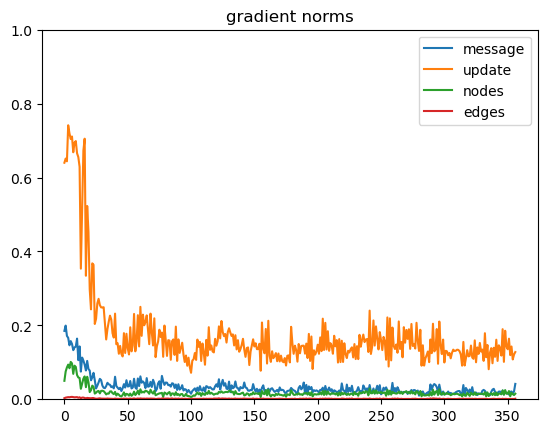

In [35]:
plt.plot([e["mgrad"] for e in log], label='message')
plt.plot([e["ugrad"] for e in log], label='update')
plt.plot([e["node_grad"] for e in log], label='nodes')
plt.plot([e["edge_grad"] for e in log], label='edges')
plt.title('gradient norms')
plt.ylim(0, 1.0)
plt.legend()
plt.show()